
---
# Load needed libraries and functions

In [1]:

%run ../load_magic/storage.py
%run ../load_magic/environment.py
from scipy.stats import entropy
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import inspect
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import numpy as np
import time
%pprint

notebook_path = get_notebook_path()
print(notebook_path)

s = Storage()
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])
try:
    basic_tags_dict = s.load_object('basic_tags_dict')
except:
    basic_tags_dict = {}
    s.store_objects(basic_tags_dict=basic_tags_dict)
dir()

Pretty printing has been turned OFF
C:\Users\dev\Documents\Repositories\job-hunting\ipynb\Indeed Header Classifier Scores.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']


['AdaBoostClassifier', 'BaggingClassifier', 'Config', 'CountVectorizer', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'In', 'LogisticRegression', 'Out', 'RandomForestClassifier', 'SVC', 'StackingClassifier', 'Storage', 'TfidfTransformer', 'VotingClassifier', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_ih', '_ii', '_iii', '_oh', 'basic_tags_dict', 'csv', 'entropy', 'exit', 'get_all_files_containing', 'get_classifier', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_importances', 'get_input_sample', 'get_ipython', 'get_module_version', 'get_modules_dataframe', 'get_notebook_path', 'get_struct_name', 'inspect', 'ipykernel', 'json', 'jupyter_config_dir', 'notebook_path', 'notebookapp', 'np', 'os', 'pd', 'pickle', 'plt', 'preprocess_data', 'quit', 're', 's', 'set_matplotlib_formats', 'subprocess', 'sys', 'time', 'urllib']

In [2]:

len(basic_tags_dict.keys())

83


---
# Needed extra functions

In [3]:

scanner_regex = re.compile(r'(</?|\b)[1-9a-zA-Z][0-9a-zA-Z]*( *[#\+]{1,2}|>|\b)')
def regex_tokenizer(corpus):
    
    return [match.group() for match in re.finditer(scanner_regex, corpus)]


---
# Training

In [4]:

# Rebuild the datframe from the dictionary
rows_list = [{'html_tag_str': html_tag_str, 'is_fit': is_fit} for html_tag_str, is_fit in basic_tags_dict.items()]
basic_tags_df = pd.DataFrame(rows_list, columns=['html_tag_str', 'is_fit'])
s.store_objects(basic_tags_df=basic_tags_df)

# Re-transform the bag-of-words and tf-idf from the new manual scores
sents_list = basic_tags_df.html_tag_str.tolist()
if len(sents_list):
    
    # Bag-of-words
    cv = CountVectorizer(lowercase=True, tokenizer=regex_tokenizer, ngram_range=(1, 3))
    bow_matrix = cv.fit_transform(sents_list)
    s.store_objects(bq_cv_vocab=cv.vocabulary_)
    
    # Tf-idf, must get from BOW first
    tt = TfidfTransformer()
    tfidf_matrix = tt.fit_transform(bow_matrix)
    s.store_objects(bq_tt=tt)
    
    # Re-train the classifier
    X = tfidf_matrix.toarray()
    y = basic_tags_df.is_fit.to_numpy()
    fit_estimators_dict = s.load_object('fit_estimators_dict')
    #basic_tags_clf = RandomForestClassifier(n_estimators=997)
    #basic_tags_clf = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None)
    basic_tags_clf = fit_estimators_dict['LogisticRegression']
    basic_tags_clf.fit(X, y)
    s.store_objects(basic_tags_clf=basic_tags_clf)
    
    # Re-calibrate the inference engine
    bq_cv_vocab = s.load_object('bq_cv_vocab')
    bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
    bq_cv._validate_vocabulary()
    bq_tt = s.load_object('bq_tt')
    def predict_percent_fit(quals_list):
        y_predict_proba = np.array([])
        if len(quals_list):
            X_test = bq_tt.transform(bq_cv.transform(quals_list)).toarray()
            y_predict_proba = basic_tags_clf.predict_proba(X_test)

        return y_predict_proba
print('Retraining complete')

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_df.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\bq_cv_vocab.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\bq_tt.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_clf.pickle
Retraining complete



---
# Rescore the quals dataframe

In [15]:

# Get the training data and models
if len(sents_list):
    X = tfidf_matrix.toarray()
    y = basic_tags_df.is_fit.to_numpy()
    estimators_list = [AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None),
                       BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False),
                       ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=None,
                                            max_features='auto', max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False),
                       GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance',
                                                  max_depth=3,
                                                  max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                                                  min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
                                                  n_iter_no_change=None, presort='deprecated', random_state=None, subsample=1.0, tol=0.0001,
                                                  validation_fraction=0.1, verbose=0, warm_start=False),
                       RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_impurity_split=None,
                                              min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
                                              n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False),
                       LogisticRegression(**{'C': 85.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'max_iter': 6,
                                             'penalty': 'l2', 'solver': 'sag', 'tol': 1e-08}),
                       SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
                           verbose=False)]

    # Fit the data and add the duration and fitted models to lists
    fit_estimators_list = []
    training_durations_list = []
    for clf in estimators_list:
        start_time = time.time()
        fit_estimators_list.append(clf.fit(X, y))
        stop_time = time.time()
        training_durations_list.append(stop_time - start_time)
    s.store_objects(estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\estimators_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\training_durations_list.pickle


In [16]:

try:
    estimators_list = s.load_object('estimators_list')
except:
    estimators_list = []
    s.store_objects(estimators_list=estimators_list)
if len(estimators_list):
    inference_durations_list = []
    for clf in estimators_list:
        clf_name = str(type(clf)).split('.')[-1].split("'")[0]
        basic_tags_df[clf_name] = np.nan
        start_time = time.time()
        for row_index, row_series in basic_tags_df.iterrows():
            html_tag_str = row_series.html_tag_str
            X_test = bq_tt.transform(bq_cv.transform([html_tag_str])).toarray()
            y_predict_proba = clf.predict_proba(X_test)[0][1]
            basic_tags_df.loc[row_index, clf_name] = y_predict_proba
        stop_time = time.time()
        inference_durations_list.append(stop_time - start_time)
    s.store_objects(basic_tags_df=basic_tags_df, inference_durations_list=inference_durations_list)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_df.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\inference_durations_list.pickle


In [17]:

try:
    estimators_list = s.load_object('estimators_list')
except:
    estimators_list = []
    s.store_objects(estimators_list=estimators_list)
if len(estimators_list):
    clf = StackingClassifier(estimators=[(str(type(e)).split('.')[-1].split("'")[0], e) for e in estimators_list],
                             final_estimator=None, cv=None, stack_method='auto', n_jobs=None, passthrough=False, verbose=0)
    clf_name = str(type(clf)).split('.')[-1].split("'")[0]
    basic_tags_df = s.load_object('basic_tags_df')
    basic_tags_df[clf_name] = np.nan
    fit_estimators_list = estimators_list.copy()
    bq_cv_vocab = s.load_object('bq_cv_vocab')
    bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
    bq_cv._validate_vocabulary()
    bq_tt = s.load_object('bq_tt')
    X = bq_tt.transform(bq_cv.transform(basic_tags_df.html_tag_str.tolist())).toarray()
    y = basic_tags_df.is_fit.to_numpy()
    start_time = time.time()
    fit_estimators_list.append(clf.fit(X, y))
    stop_time = time.time()
    training_durations_list = s.load_object('training_durations_list')
    training_durations_list.append(stop_time - start_time)
    s.store_objects(fit_estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

    # Re-score the quals dataframe
    inference_durations_list = s.load_object('inference_durations_list')
    start_time = time.time()
    for row_index, row_series in basic_tags_df.iterrows():
        html_tag_str = row_series.html_tag_str
        X_test = bq_tt.transform(bq_cv.transform([html_tag_str])).toarray()
        y_predict_proba = clf.predict_proba(X_test)[0][1]
        basic_tags_df.loc[row_index, clf_name] = y_predict_proba
    stop_time = time.time()
    inference_durations_list.append(stop_time - start_time)
    s.store_objects(basic_tags_df=basic_tags_df, inference_durations_list=inference_durations_list)

C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The m

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\fit_estimators_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\training_durations_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_df.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\inference_durations_list.pickle


In [18]:

if len(estimators_list):
    clf = VotingClassifier(estimators=[(str(type(e)).split('.')[-1].split("'")[0], e) for e in estimators_list],
                           voting='soft', weights=None, n_jobs=None, flatten_transform=True)
    clf_name = str(type(clf)).split('.')[-1].split("'")[0]
    basic_tags_df[clf_name] = np.nan
    fit_estimators_list = s.load_object('fit_estimators_list')
    start_time = time.time()
    fit_estimators_list.append(clf.fit(X, y))
    stop_time = time.time()
    training_durations_list = s.load_object('training_durations_list')
    training_durations_list.append(stop_time - start_time)
    s.store_objects(fit_estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

    # Re-score the quals dataframe
    bq_cv_vocab = s.load_object('bq_cv_vocab')
    bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
    bq_cv._validate_vocabulary()
    bq_tt = s.load_object('bq_tt')
    inference_durations_list = s.load_object('inference_durations_list')
    start_time = time.time()
    for row_index, row_series in basic_tags_df.iterrows():
        html_tag_str = row_series.html_tag_str
        X_test = bq_tt.transform(bq_cv.transform([html_tag_str])).toarray()
        y_predict_proba = clf.predict_proba(X_test)[0][1]
        basic_tags_df.loc[row_index, clf_name] = y_predict_proba
    stop_time = time.time()
    inference_durations_list.append(stop_time - start_time)
    s.store_objects(basic_tags_df=basic_tags_df, inference_durations_list=inference_durations_list)

C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\fit_estimators_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\training_durations_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_df.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\inference_durations_list.pickle


In [19]:

try:
    basic_tags_df = s.load_object('basic_tags_df')
except:
    columns_list = ['html_tag_str', 'is_fit', 'AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier',
                    'RandomForestClassifier', 'LogisticRegression', 'SVC', 'StackingClassifier', 'VotingClassifier']
    basic_tags_df = pd.DataFrame([], columns=columns_list)
    s.store_objects(basic_tags_df=basic_tags_df)
print(basic_tags_df.columns.tolist())
basic_tags_df.sample(5).T

['html_tag_str', 'is_fit', 'AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier', 'LogisticRegression', 'SVC', 'StackingClassifier', 'VotingClassifier']


,21,76,29,23,51
html_tag_str,<div>Mission</div>,<li>Bachelor’s Degree or higher in a mathemati...,<p>COVID-19 Precaution(s):</p>,We’re looking for a well-rounded Senior Data S...,<li>A love for writing beautiful code; you don...
is_fit,True,False,True,False,False
AdaBoostClassifier,0.272481,0.231729,0.789302,0.231729,0.272481
BaggingClassifier,0.1,0,0,0,0
ExtraTreesClassifier,0.23,0.02,0.14,0.04,0.05
GradientBoostingClassifier,0.0170042,0.00222135,0.00647455,0.00222135,0.00222135
RandomForestClassifier,0.22,0.07,0.23,0.04,0.06
LogisticRegression,0.266774,0.00342411,0.953491,0.00286965,0.00922519
SVC,0.59145,0.0611475,0.644741,0.0188123,0.0500838
StackingClassifier,0.747932,0.0421548,0.768219,0.0436313,0.0419563


In [20]:

metrics_list = ['accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score',
                'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score',
                'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score',
                'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']
exec('from sklearn.metrics import {}'.format(', '.join(metrics_list)))
try:
    fit_estimators_list = s.load_object('fit_estimators_list')
except:
    fit_estimators_list = []
    s.store_objects(fit_estimators_list=fit_estimators_list)
if len(fit_estimators_list):
    clf_name_list = [str(type(clf)).split('.')[-1].split("'")[0] for clf in fit_estimators_list]
    basic_tags_df = s.load_object('basic_tags_df')
    y_true = basic_tags_df.is_fit.tolist()
    fit_match_series = (basic_tags_df.is_fit == 1)
    yes_list = basic_tags_df[fit_match_series].is_fit.tolist()
    no_list = basic_tags_df[~fit_match_series].is_fit.tolist()
    columns_list = ['clf_name', 'training_duration', 'inference_duration', 'boundary_diff', 'clf_yes_entropy',
                    'relative_yes_entropy'] + metrics_list
    rows_list = []
    training_durations_list = s.load_object('training_durations_list')
    inference_durations_list = s.load_object('inference_durations_list')
    for column_name, training_duration, inference_duration in zip(clf_name_list, training_durations_list, inference_durations_list):
        yes_series = basic_tags_df[fit_match_series][column_name]
        upper_bound = yes_series.min()
        no_series = basic_tags_df[~fit_match_series][column_name]
        lower_bound = no_series.max()
        y_pred = []
        for p in basic_tags_df[column_name]:
            if p > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
        row_dict = {}
        row_dict['clf_name'] = column_name
        row_dict['training_duration'] = training_duration
        row_dict['inference_duration'] = inference_duration
        row_dict['boundary_diff'] = upper_bound-lower_bound
        row_dict['clf_yes_entropy'] = entropy(pk=yes_series.tolist())
        row_dict['relative_yes_entropy'] = entropy(pk=yes_list, qk=yes_series.tolist())
        for metric_str in metrics_list:
            try:
                row_dict[metric_str] = eval('{}(y_true, basic_tags_df[column_name].tolist())'.format(metric_str))
            except Exception as e1:
                try:
                    row_dict[metric_str] = eval('{}(y_true, y_pred)'.format(metric_str))
                except Exception as e2:
                    row_dict[metric_str] = np.nan
        rows_list.append(row_dict)
    entropy_df = pd.DataFrame(rows_list, columns=columns_list).dropna(axis='columns', how='all')
    entropy_df.set_index('clf_name', drop=True, inplace=True)
    s.store_objects(entropy_df=entropy_df)

C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedM

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\entropy_df.pickle


In [21]:

if len(metrics_list):
    description_dict = {name: fn.__doc__.strip().split('\n')[0] for name, fn in inspect.getmembers(sys.modules[__name__],
                                                                                                   inspect.isfunction) if name in metrics_list}
    try:
        entropy_df = s.load_object('entropy_df')
    except:
        columns_list = ['training_duration', 'inference_duration', 'boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy', 'accuracy_score',
                        'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score', 'balanced_accuracy_score',
                        'cohen_kappa_score', 'completeness_score', 'explained_variance_score', 'f1_score', 'fowlkes_mallows_score',
                        'homogeneity_score', 'jaccard_score', 'mutual_info_score', 'normalized_mutual_info_score', 'precision_score', 'r2_score',
                        'recall_score', 'roc_auc_score', 'v_measure_score']
        entropy_df = pd.DataFrame([], columns=columns_list)
        s.store_objects(entropy_df=entropy_df)
    for name, cls in inspect.getmembers(sys.modules[__name__], inspect.isclass):
        if name in entropy_df.index:
            description_dict[name] = cls.__doc__.strip().split('\n')[0]
    s.store_objects(metrics_list=metrics_list, description_dict=description_dict)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\metrics_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\description_dict.pickle


In [22]:

print(entropy_df.columns.tolist())
metrics_list

['training_duration', 'inference_duration', 'boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score', 'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score', 'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score', 'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']


['accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score', 'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score', 'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score', 'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']

In [23]:

columns_list = ['training_duration', 'inference_duration', 'balanced_accuracy_score', 'r2_score']
entropy_df[columns_list].sort_values('balanced_accuracy_score', ascending=False)

,training_duration,inference_duration,balanced_accuracy_score,r2_score
clf_name,,,,
StackingClassifier,19.249213,8.787665,1.000000,0.892923
VotingClassifier,3.554282,7.498577,1.000000,0.947512
SVC,0.474882,0.406637,0.947368,0.802357
LogisticRegression,0.062496,0.345036,0.631579,0.367586
AdaBoostClassifier,1.071135,2.659908,0.526316,0.082380
BaggingClassifier,0.276588,0.912106,0.500000,-0.271620
ExtraTreesClassifier,0.630152,3.290433,0.500000,0.182382
GradientBoostingClassifier,1.682821,0.603570,0.500000,-0.284250
RandomForestClassifier,0.694886,3.330910,0.500000,0.210094


In [24]:

fit_estimators_list = s.load_object('fit_estimators_list')
fit_estimators_dict = {str(type(clf)).split('.')[-1].split("'")[0]: clf for clf in fit_estimators_list}
s.store_objects(fit_estimators_dict=fit_estimators_dict)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\fit_estimators_dict.pickle



----

precision_score: Compute the precision
f1_score: Compute the F1 score, also known as balanced F-score or F-measure


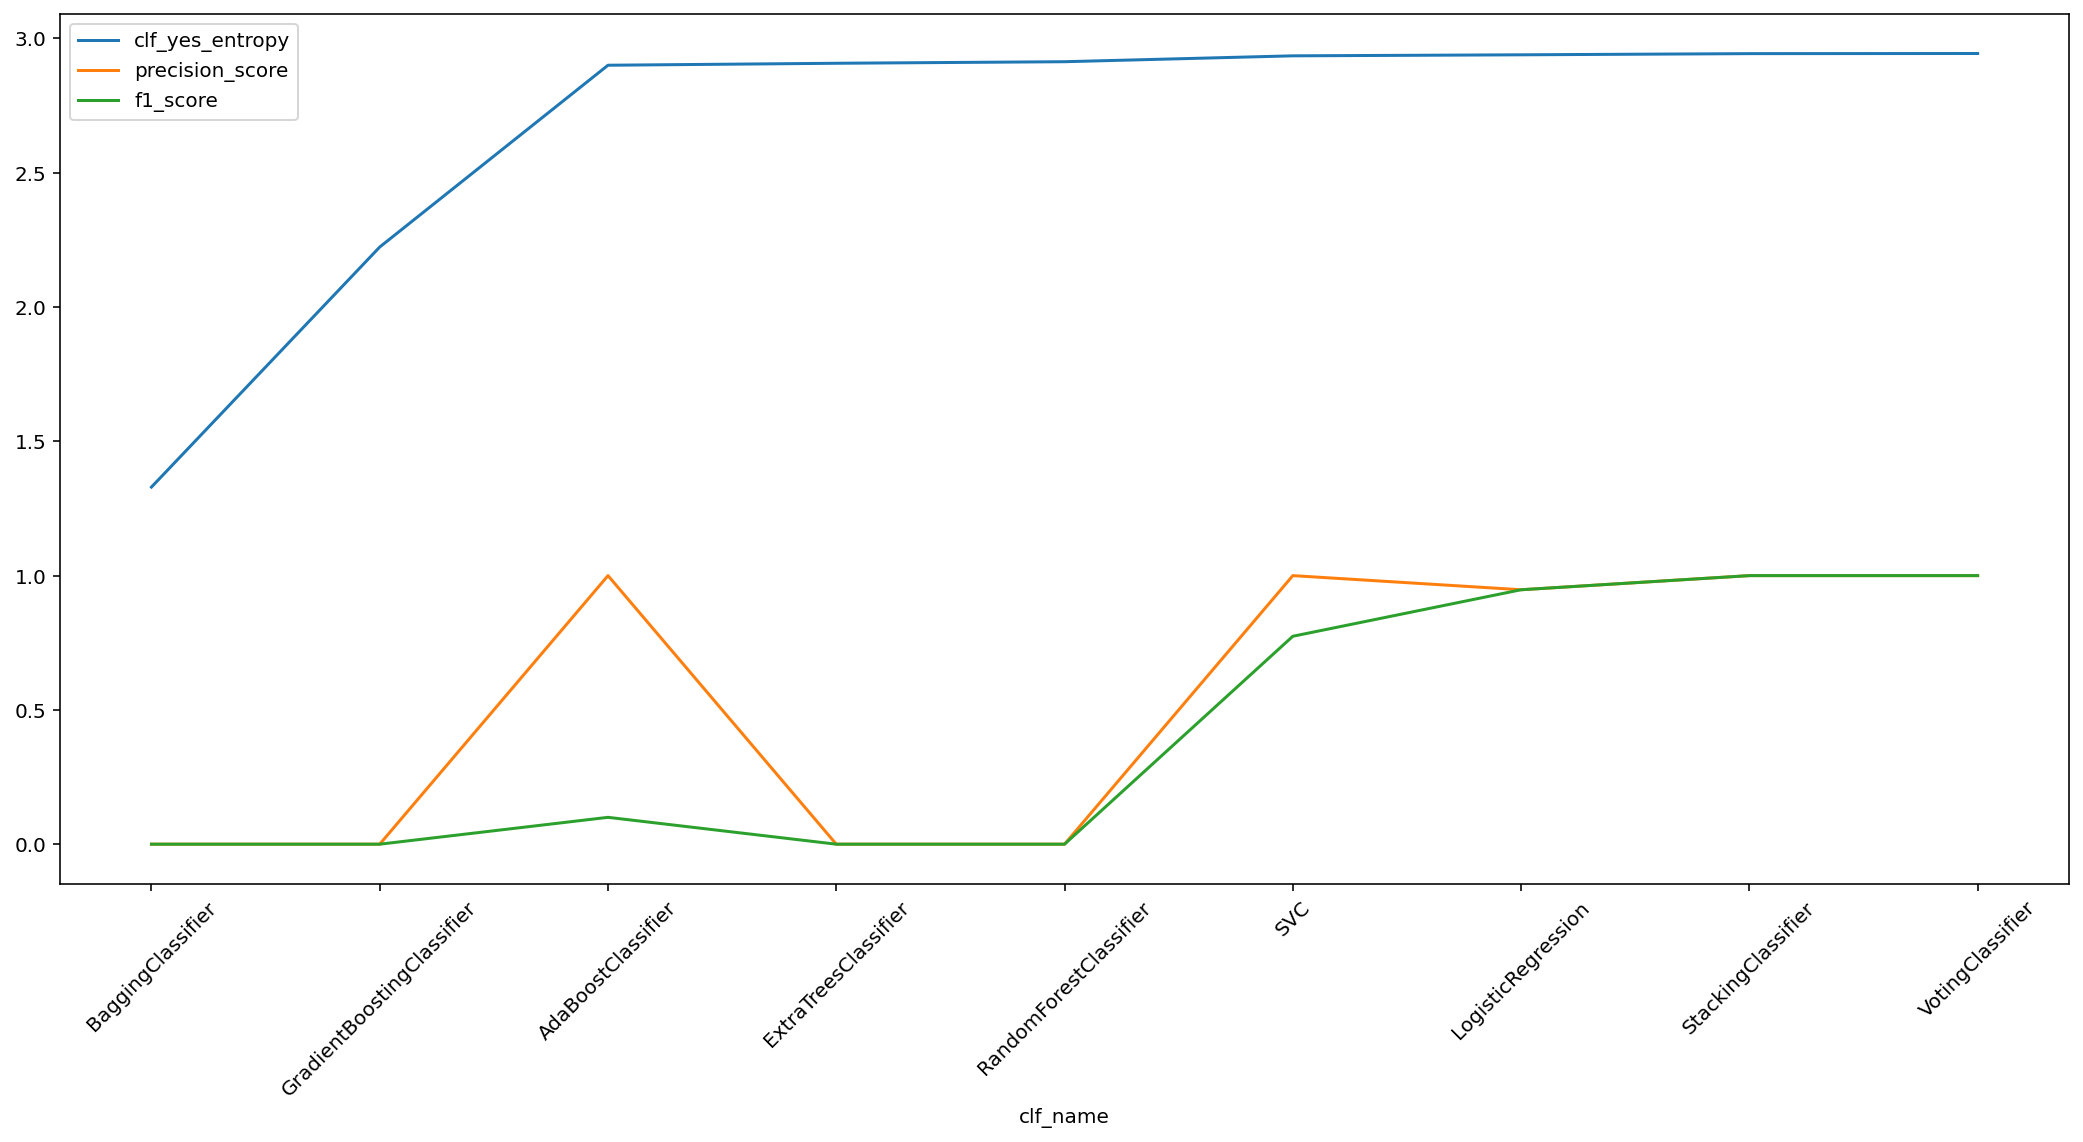

In [60]:

entropy_df = s.load_object('entropy_df')
if entropy_df.shape[0]:
    metrics_list = s.load_object('metrics_list')
    custom_metrics_list = ['boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy']
    columns_list = metrics_list + custom_metrics_list
    columns_list = [cn for cn, s in sorted([(cn, entropy_df[cn].std()) for cn in columns_list], key=lambda x: x[1], reverse=True)][:3]
    description_dict = s.load_object('description_dict')
    for metric in columns_list:
        if metric in description_dict:
            print('{}: {}'.format(metric, description_dict[metric]))
    df = entropy_df.sort_values(columns_list[0], ascending=True)[columns_list]
    AxesSubplot_obj = df.plot.line(rot=45, figsize=(18, 8))

In [68]:

from IPython.display import display

row_dict = {}
for column_name in df.columns:
    row_dict[column_name] = df[column_name].std()
display(df.append(pd.DataFrame([row_dict], index=['Standard Deviation'])))

,clf_yes_entropy,precision_score,f1_score
BaggingClassifier,1.329661,0.000000,0.000000
GradientBoostingClassifier,2.223485,0.000000,0.000000
AdaBoostClassifier,2.900370,1.000000,0.100000
ExtraTreesClassifier,2.907697,0.000000,0.000000
RandomForestClassifier,2.913489,0.000000,0.000000
SVC,2.935374,1.000000,0.774194
LogisticRegression,2.939187,0.947368,0.947368
StackingClassifier,2.943548,1.000000,1.000000
VotingClassifier,2.944079,1.000000,1.000000
Standard Deviation,0.554253,0.521764,0.485306


balanced_accuracy_score: Compute the balanced accuracy
r2_score: R^2 (coefficient of determination) regression score function.


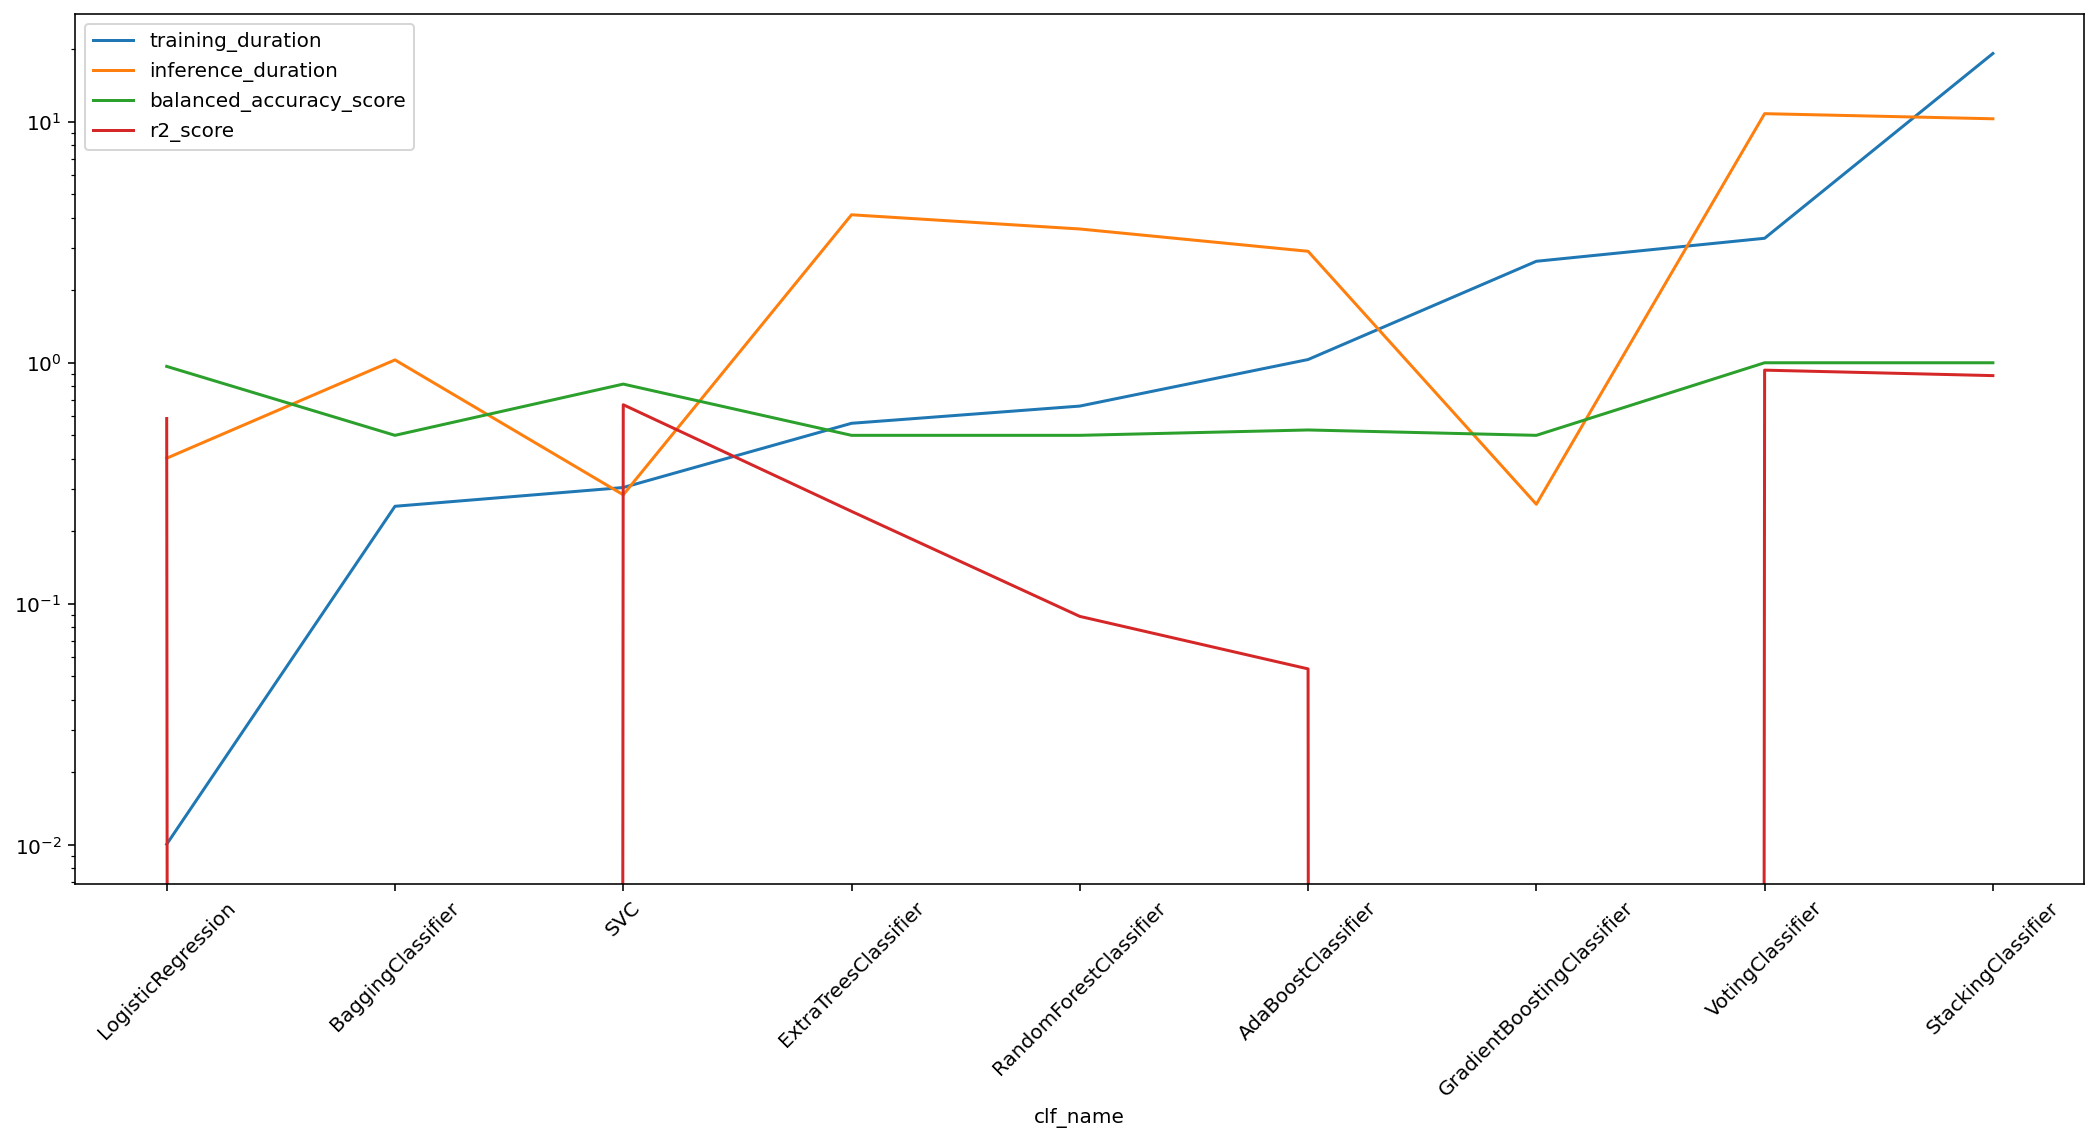

In [54]:

if entropy_df.shape[0]:
    description_dict = s.load_object('description_dict')
    columns_list = ['training_duration', 'inference_duration', 'balanced_accuracy_score', 'r2_score']
    for metric in columns_list:
        if metric in description_dict:
            print('{}: {}'.format(metric, description_dict[metric]))
    entropy_df = s.load_object('entropy_df')
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_yscale('log')
    AxesSubplot_obj = entropy_df.sort_values(columns_list[0], ascending=True)[columns_list].plot.line(rot=45, ax=ax)

accuracy_score: Accuracy classification score.
balanced_accuracy_score: Compute the balanced accuracy


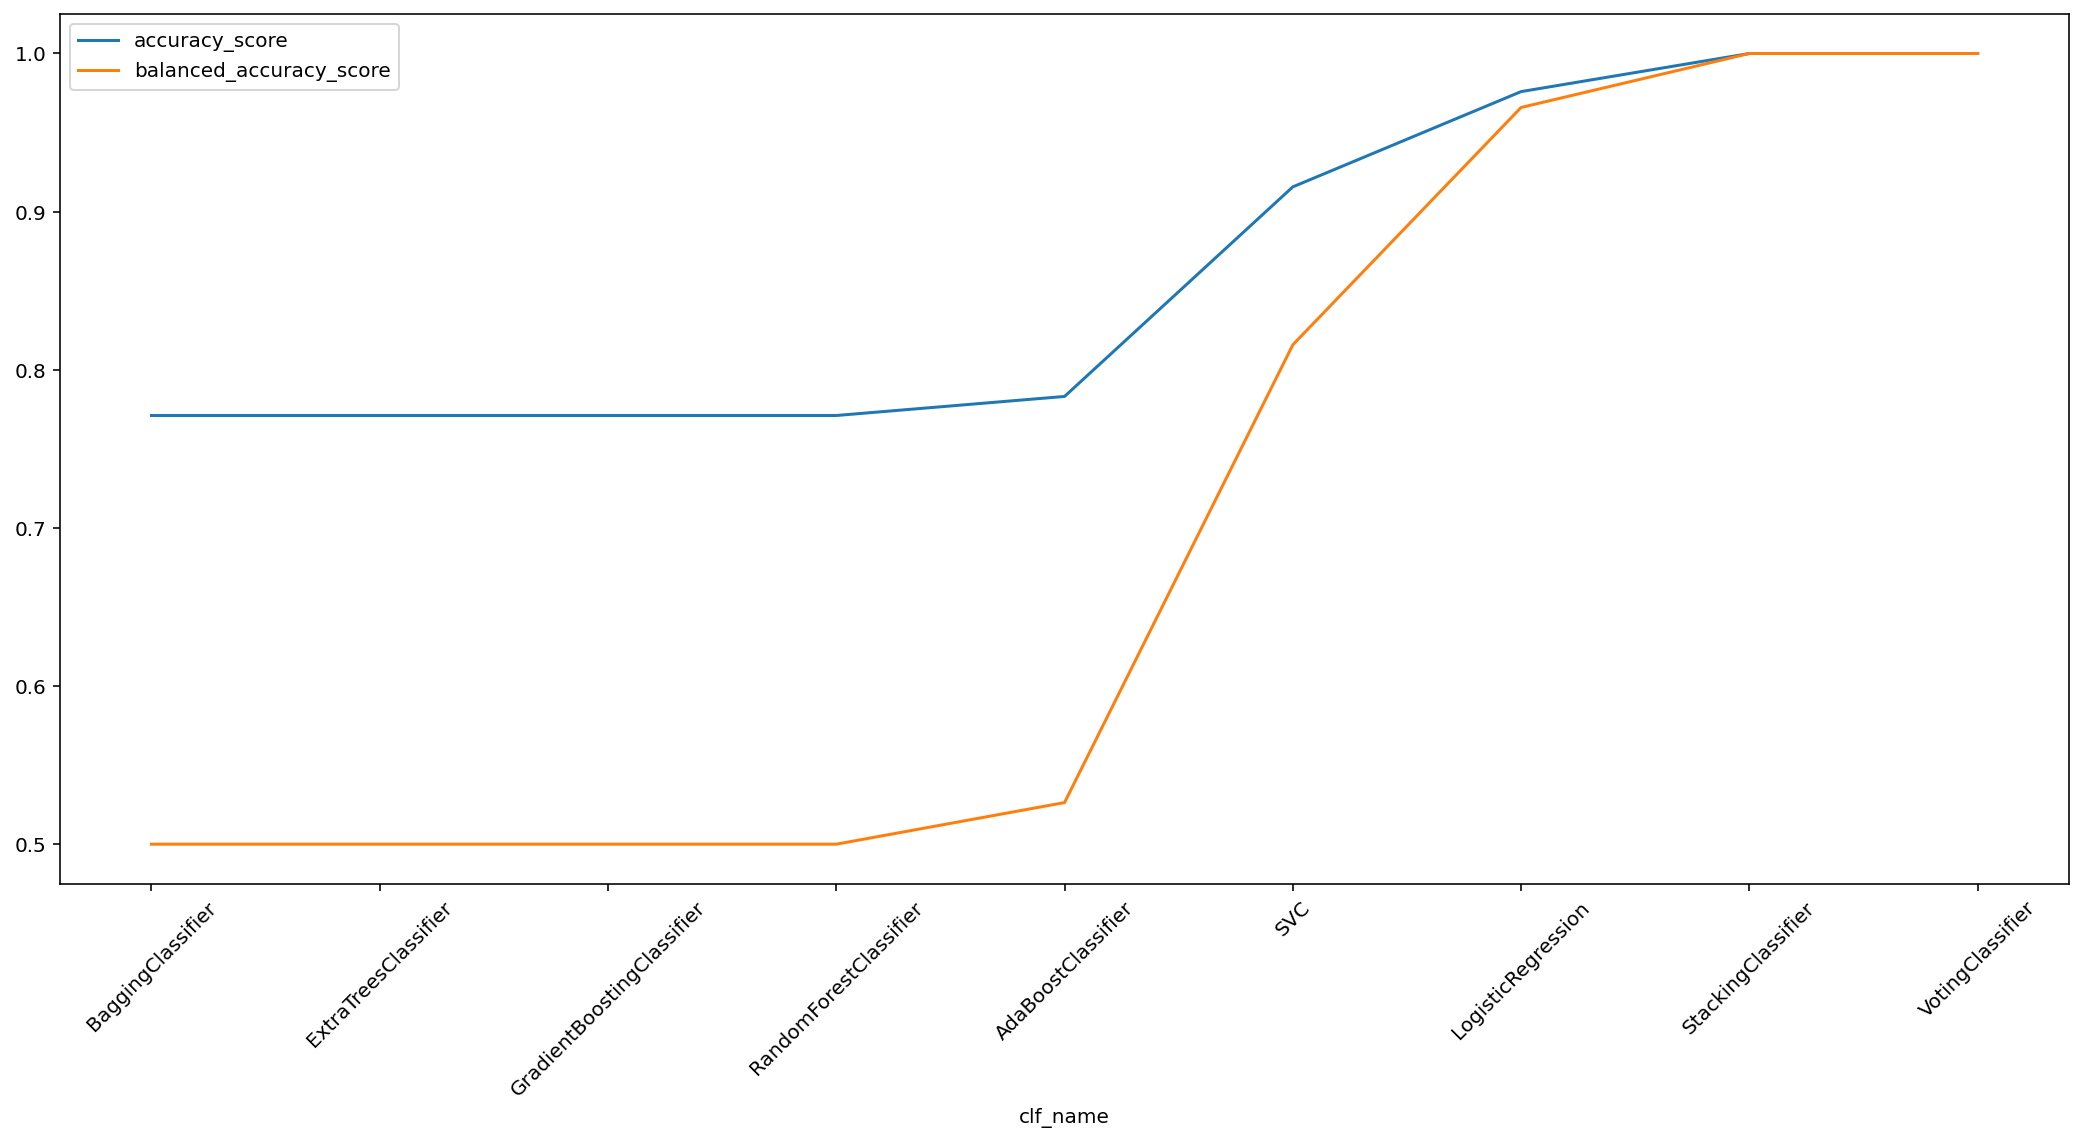

In [55]:

if entropy_df.shape[0]:
    metrics_list = s.load_object('metrics_list')
    columns_list = [cn for cn in metrics_list if 'accur' in cn.lower()]
    for metric in columns_list:
        if metric in description_dict:
            print('{}: {}'.format(metric, description_dict[metric]))
    AxesSubplot_obj = entropy_df.sort_values(columns_list[0], ascending=True)[columns_list].plot.line(rot=45, figsize=(18, 8))

In [56]:

entropy_df.sort_values('boundary_diff', ascending=False)[custom_metrics_list]

,boundary_diff,clf_yes_entropy,relative_yes_entropy
clf_name,,,
StackingClassifier,0.475645,2.943548,0.000914
VotingClassifier,0.450088,2.944079,0.000360
SVC,0.078540,2.935374,0.009309
GradientBoostingClassifier,-0.001689,2.223485,0.469096
RandomForestClassifier,-0.010000,2.913489,0.029630
LogisticRegression,-0.014039,2.939187,0.005394
ExtraTreesClassifier,-0.030000,2.907697,0.038824
AdaBoostClassifier,-0.119806,2.900370,0.039584
BaggingClassifier,-0.200000,1.329661,inf


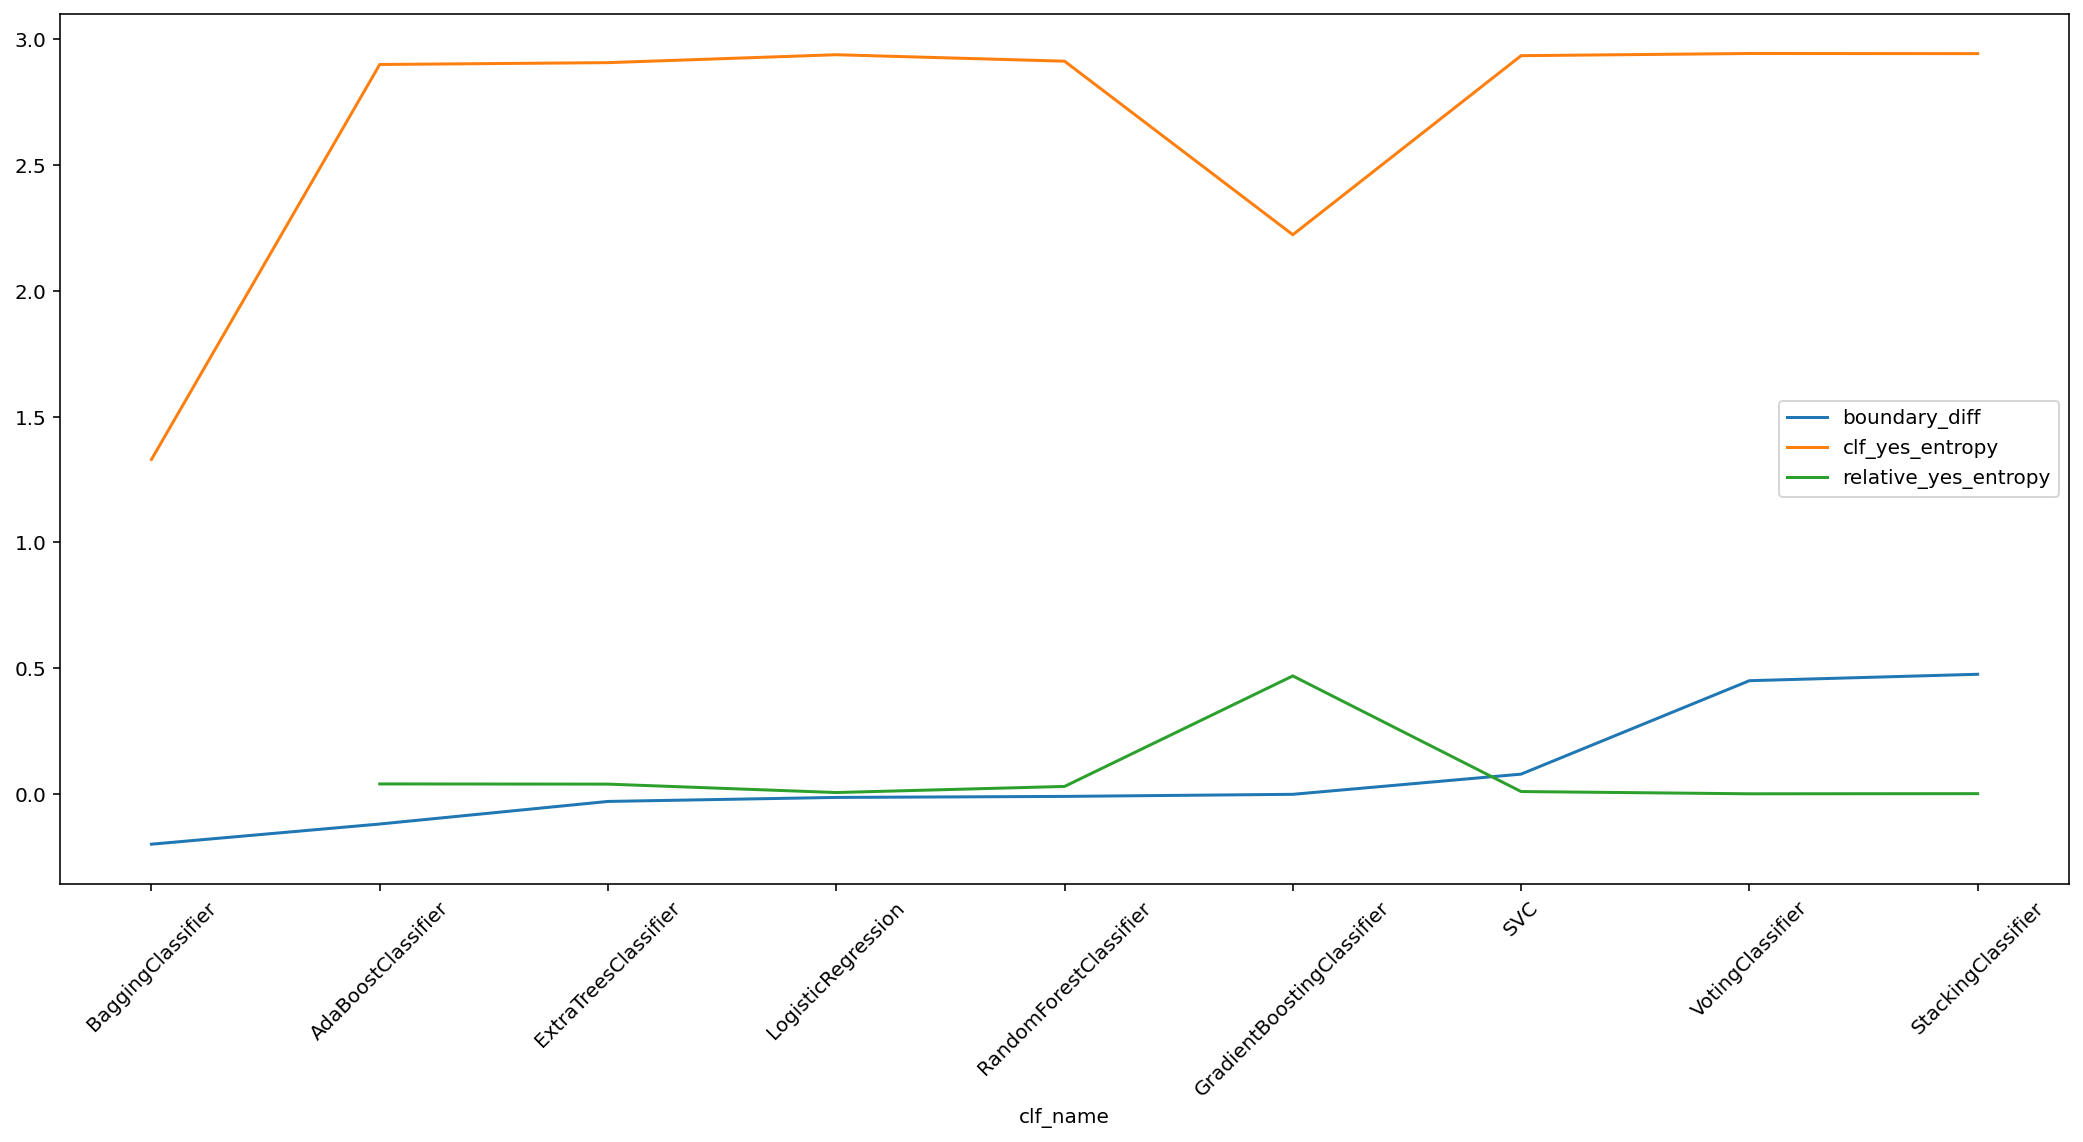

In [57]:

if entropy_df.shape[0]:
    for metric in custom_metrics_list:
        if metric in description_dict:
            print('{}: {}'.format(metric, description_dict[metric]))
    AxesSubplot_obj = entropy_df.sort_values('boundary_diff', ascending=True)[custom_metrics_list].plot.line(rot=45, figsize=(18, 8))

average_precision_score: Compute average precision (AP) from prediction scores
precision_score: Compute the precision
recall_score: Compute the recall


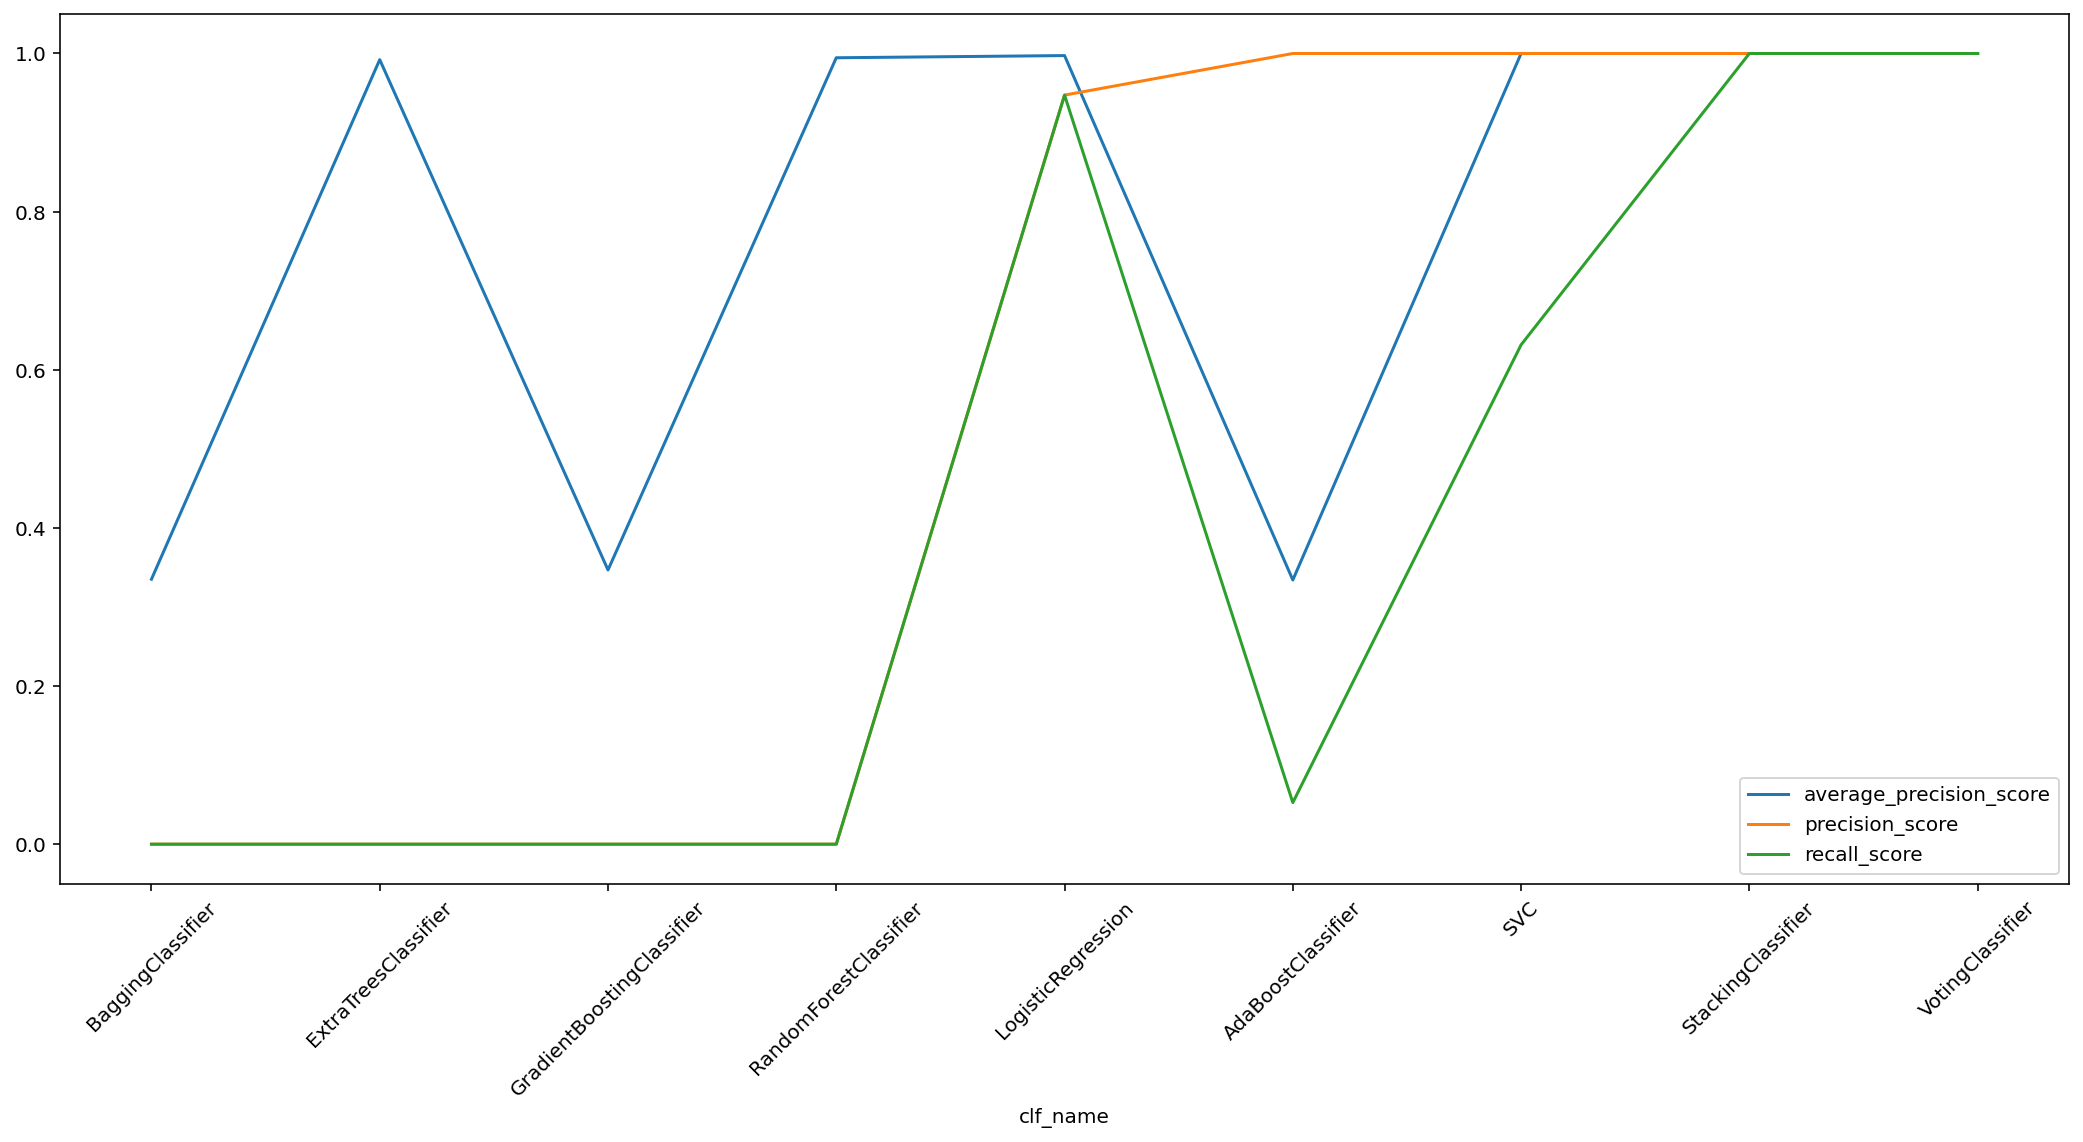

In [58]:

entropy_df = s.load_object('entropy_df')
if entropy_df.shape[0]:
    columns_list = ['average_precision_score', 'precision_score', 'recall_score']
    description_dict = s.load_object('description_dict')
    for metric in columns_list:
        print('{}: {}'.format(metric, description_dict[metric]))
    AxesSubplot_obj = entropy_df.sort_values('precision_score', ascending=True)[columns_list].plot.line(rot=45, figsize=(18, 8))

In [59]:

columns_list = ['average_precision_score', 'precision_score', 'recall_score']
extended_columns_list = ['training_duration', 'inference_duration'] + columns_list
entropy_df.sort_values('precision_score', ascending=True)[extended_columns_list]

,training_duration,inference_duration,average_precision_score,precision_score,recall_score
clf_name,,,,,
BaggingClassifier,0.253924,1.027712,0.335109,0.000000,0.000000
ExtraTreesClassifier,0.560941,4.110056,0.992217,0.000000,0.000000
GradientBoostingClassifier,2.636217,0.258856,0.346811,0.000000,0.000000
RandomForestClassifier,0.661233,3.588459,0.994598,0.000000,0.000000
LogisticRegression,0.010072,0.401956,0.997368,0.947368,0.947368
AdaBoostClassifier,1.031355,2.900066,0.334123,1.000000,0.052632
SVC,0.303757,0.283389,1.000000,1.000000,0.631579
StackingClassifier,19.178865,10.280340,1.000000,1.000000,1.000000
VotingClassifier,3.284081,10.795283,1.000000,1.000000,1.000000
